## Evaluation of Classification Model


### Problem of Classification without Evaluation

In [1]:
import pandas as pd


# read titanic data
data = pd.read_csv("train.csv")
print(data.columns)

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


In [2]:
import numpy as np
from sklearn.base import BaseEstimator
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


# create custom estimator
class DummyClassifier(BaseEstimator):
    def fit(self, X, y=None):
        pass

    def predict(self, X):
        # create default list with row len(X.shape[0]) and column 1
        pred = np.zeros( (X.shape[0], 1), dtype="int32" )
        for i in range(X.shape[0]):
            pred[i] = 0 if X["Sex"].iloc[i] == "male" else 1
        
        return np.array(pred)
        
# define feature and target
Y_data = data[["Survived"]]
X_data = data.drop(["Survived"], axis=1)

# split train and test split
X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data, test_size=0.2, random_state=0)

model = DummyClassifier()
model.fit(X_train, Y_train)
pred = model.predict(X_test)
score = accuracy_score(pred, Y_test)

# accuracy: apprx 78%
print(score)

0.7877094972067039


- Simple Estimator can predict test set as 78%, so using accuracy_score is very dangerous.



In [3]:
# problem demonstration with imbalanced dataset
from sklearn.datasets import load_digits

# read MNIST dataset
# digits: <sklearn.utils._bunch.Bunch>
digits = load_digits()

In [4]:
# create custom estimator
class DummyEstimator2(BaseEstimator):
    def fit(self, X, Y=None):
        pass

    def predict(self, X):
        return np.zeros( (len(X), 1), dtype=bool)
        
# y: create imbalance targets
y = (digits.target==7).astype(int)
X_train, X_test, Y_train, Y_test = train_test_split(digits.data, y, random_state=11)
print(f"Size of Test Set: {X_test.shape}")
print(f"Distribution of Test Set\n{pd.Series(Y_test).value_counts()}")

Size of Test Set: (450, 64)
Distribution of Test Set
0    405
1     45
Name: count, dtype: int64


In [5]:
model = DummyEstimator2()
model.fit(X_train, Y_train)
pred = model.predict(X_test)
print(f"Accuracy Score: {np.round(accuracy_score(pred, Y_test))}")

Accuracy Score: 1.0


* Only accuracy metric can not be used to evaluate the result of prediction.

### Confusion Matrix

<table>
    <tr>
        <td></td>
        <td>Predicted as Negative(0)</td>
        <td>Predicted as Positive(1)</td>
    </tr>
    <tr>
        <td>Real as Negative(0)</td>
        <td>True Negative:
Right Prediction to Negative</td>
        <td>False Positive:
False Prediction to Negative</td>
    </tr>
    <tr>
        <td>Real as Positive(1)</td>
        <td>False Negative:
False Prediction to Positive</td>
        <td>True Positive:
True Prediction to Positive</td>
    </tr>
</table>

* accuracy  = (TP + FN) / (TP + FP + FN + TN)
* precision = TP / (FP + TP)
* recall = TP / (FN + TP)

In [6]:
# Titinic data with confusion Matrix
target_data = data["Survived"]
features_data = data.drop(["Survived", "PassengerId", "Name", "Ticket"], axis=1)

#preprocessing: fill NA
# check NA
contain_na_features = []
for col in features_data.columns:
    if any(features_data[col].isnull()):
        contain_na_features.append(col) 

# N/A: Age, Cabin, Embarked
contain_na_features

# fill na for Age
features_data.fillna({"Age": features_data["Age"].mean(), "Embarked": "N"}, inplace=True)

# fill na for Cabin
features_data["Cabin"] = (features_data["Cabin"].apply(lambda x: str(x)[0].upper()))

# Encoding

from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# Encoding "Sex": "Male(1)", "Female(0)"
label = features_data["Sex"].unique()
encoder = LabelEncoder()
encoder.fit(label)
features_data["Sex"] = encoder.transform(features_data["Sex"])


# Encding "Cabin"
label = np.array(features_data["Cabin"])
tmp = pd.DataFrame({"Cabin": label})
result = pd.get_dummies(tmp, dtype="int32")

for col in result.columns:
    features_data[col] = result[col]

# Encoding "Embarked"
label = np.array(features_data["Embarked"])
tmp = pd.DataFrame({"Embarked": label})
result = pd.get_dummies(tmp, dtype="int32")

for col in result.columns:
    features_data[col] = result[col]

features_data.drop(["Cabin", "Embarked"], axis=1, inplace=True)


In [7]:
# Confusion Matrix with Classification
model = LogisticRegression()

X_train, X_test, Y_train, Y_test = train_test_split(features_data, target_data, test_size=0.2, random_state=11)
model.fit(X_train, Y_train)
pred = model.predict(X_test)


/home/luna-negra/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [8]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score

print(f"Confusion Matrix:")
print(confusion_matrix(pred, Y_test))
print(f"Accuracy_Score: {np.round(accuracy_score(pred, Y_test), 2)}")
print(f"Precision_Score: {np.round(precision_score(pred, Y_test), 2)}")
print(f"Recall_Score: {np.round(recall_score(pred, Y_test), 2)}")

Confusion Matrix:
[[105  13]
 [ 13  48]]
Accuracy_Score: 0.85
Precision_Score: 0.79
Recall_Score: 0.79


### Precision / Recall Trade Off
- Precision and Recall are complementary values.
- Edit Threshold by calibrating critical value, which is called 'trade-off'

In [9]:
# basically, trade-off value is 50:50
# can check the individual result by calling predict_proba from the model class which has predicted test data.
pred_proba = model.predict_proba(X_test)

#  Negative Probability  /  Positive Probability
pred_proba

array([[0.4673352 , 0.5326648 ],
       [0.88171018, 0.11828982],
       [0.85591518, 0.14408482],
       [0.87044642, 0.12955358],
       [0.86183053, 0.13816947],
       [0.89072756, 0.10927244],
       [0.89102572, 0.10897428],
       [0.2018897 , 0.7981103 ],
       [0.80360044, 0.19639956],
       [0.38295001, 0.61704999],
       [0.90787736, 0.09212264],
       [0.879714  , 0.120286  ],
       [0.85589319, 0.14410681],
       [0.89088121, 0.10911879],
       [0.51554453, 0.48445547],
       [0.86354261, 0.13645739],
       [0.88534964, 0.11465036],
       [0.76066972, 0.23933028],
       [0.4921851 , 0.5078149 ],
       [0.15587625, 0.84412375],
       [0.77918701, 0.22081299],
       [0.71714181, 0.28285819],
       [0.85927576, 0.14072424],
       [0.80497603, 0.19502397],
       [0.88970994, 0.11029006],
       [0.79200538, 0.20799462],
       [0.87241703, 0.12758297],
       [0.92047013, 0.07952987],
       [0.74833151, 0.25166849],
       [0.45653188, 0.54346812],
       [0.

### Simple Threshold Test

- with Binarizer, it is possible to demonstrate threshold between recall and precision
- if threshold is close to 1 (increase recall)
- else: (increase precision)

In [10]:
from sklearn.preprocessing import Binarizer

x = [[1, -1, 2],
     [2, 0, 0],
     [0, 1.1, 1.2]]

binarizer = Binarizer(threshold=1.1)
print(binarizer.fit_transform(x))

[[0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]]


In [11]:
binarizer = Binarizer(threshold=0.9)
custom_pred = binarizer.fit_transform(pred_proba[:, 1].reshape(-1, 1))

print(f"Confusion Matrix:")
print(confusion_matrix(custom_pred, Y_test))
print(f"Accuracy_Score: {np.round(accuracy_score(custom_pred, Y_test), 2)}")
print(f"Precision_Score: {np.round(precision_score(custom_pred, Y_test), 2)}")
print(f"Recall_Score: {np.round(recall_score(custom_pred, Y_test), 2)}")

Confusion Matrix:
[[118  46]
 [  0  15]]
Accuracy_Score: 0.74
Precision_Score: 0.25
Recall_Score: 1.0


In [12]:
binarizer = Binarizer(threshold=0.1)
custom_pred = binarizer.fit_transform(pred_proba[:, 1].reshape(-1, 1))

print(f"Confusion Matrix:")
print(confusion_matrix(custom_pred, Y_test))
print(f"Accuracy_Score: {np.round(accuracy_score(custom_pred, Y_test), 2)}")
print(f"Precision_Score: {np.round(precision_score(custom_pred, Y_test), 2)}")
print(f"Recall_Score: {np.round(recall_score(custom_pred, Y_test), 2)}")

Confusion Matrix:
[[20  0]
 [98 61]]
Accuracy_Score: 0.45
Precision_Score: 1.0
Recall_Score: 0.38


In [13]:

t_list = [x / 10 for x in range(1, 10)]

for thr in t_list:
    binarizer = Binarizer(threshold=thr)
    pred_tmp = pred_proba[:, 1].reshape(-1, 1)
    custom_pred = binarizer.fit_transform(pred_tmp)

    print(f"Confusion Matrix: Threshold({thr})")
    print(confusion_matrix(custom_pred, Y_test))
    print(f"Accuracy_Score: {np.round(accuracy_score(custom_pred, Y_test), 5)}")
    print(f"Precision_Score: {np.round(precision_score(custom_pred, Y_test), 5)}")
    print(f"Recall_Score: {np.round(recall_score(custom_pred, Y_test), 5)}")
    print("--\n")
    

Confusion Matrix: Threshold(0.1)
[[20  0]
 [98 61]]
Accuracy_Score: 0.45251
Precision_Score: 1.0
Recall_Score: 0.38365
--

Confusion Matrix: Threshold(0.2)
[[75  6]
 [43 55]]
Accuracy_Score: 0.72626
Precision_Score: 0.90164
Recall_Score: 0.56122
--

Confusion Matrix: Threshold(0.3)
[[91  8]
 [27 53]]
Accuracy_Score: 0.80447
Precision_Score: 0.86885
Recall_Score: 0.6625
--

Confusion Matrix: Threshold(0.4)
[[98 12]
 [20 49]]
Accuracy_Score: 0.82123
Precision_Score: 0.80328
Recall_Score: 0.71014
--

Confusion Matrix: Threshold(0.5)
[[105  13]
 [ 13  48]]
Accuracy_Score: 0.85475
Precision_Score: 0.78689
Recall_Score: 0.78689
--

Confusion Matrix: Threshold(0.6)
[[112  17]
 [  6  44]]
Accuracy_Score: 0.87151
Precision_Score: 0.72131
Recall_Score: 0.88
--

Confusion Matrix: Threshold(0.7)
[[116  28]
 [  2  33]]
Accuracy_Score: 0.8324
Precision_Score: 0.54098
Recall_Score: 0.94286
--

Confusion Matrix: Threshold(0.8)
[[117  36]
 [  1  25]]
Accuracy_Score: 0.7933
Precision_Score: 0.40984
Reca

-> can trade off recall and precision by using precision_recall_curve() method from sklearn.metrics

param: test set of features
return: precision_score, recall_score, threshold

In [27]:
from sklearn.metrics import precision_recall_curve, f1_score

pred_proba_class1 = model.predict_proba(X_test)[:, 1]
precision, recall, threshold = precision_recall_curve(Y_test, pred_proba_class1)

for idx in range(len(threshold)):
    print(f"Precision_score: {np.round(precision[idx], 4)}")
    print(f"Recall_score: {np.round(recall[idx], 4)}")
    print(f"Threshold: {np.round(threshold[idx], 4)}")
    print("--")

Precision_score: 0.3408
Recall_score: 1.0
Threshold: 0.0134
--
Precision_score: 0.3427
Recall_score: 1.0
Threshold: 0.0523
--
Precision_score: 0.3446
Recall_score: 1.0
Threshold: 0.0624
--
Precision_score: 0.3466
Recall_score: 1.0
Threshold: 0.0684
--
Precision_score: 0.3486
Recall_score: 1.0
Threshold: 0.0693
--
Precision_score: 0.3506
Recall_score: 1.0
Threshold: 0.0749
--
Precision_score: 0.3526
Recall_score: 1.0
Threshold: 0.0751
--
Precision_score: 0.3547
Recall_score: 1.0
Threshold: 0.0753
--
Precision_score: 0.3567
Recall_score: 1.0
Threshold: 0.0795
--
Precision_score: 0.3588
Recall_score: 1.0
Threshold: 0.0803
--
Precision_score: 0.3609
Recall_score: 1.0
Threshold: 0.0886
--
Precision_score: 0.3631
Recall_score: 1.0
Threshold: 0.0891
--
Precision_score: 0.3653
Recall_score: 1.0
Threshold: 0.0902
--
Precision_score: 0.3675
Recall_score: 1.0
Threshold: 0.0903
--
Precision_score: 0.3697
Recall_score: 1.0
Threshold: 0.0921
--
Precision_score: 0.372
Recall_score: 1.0
Threshold: 0.0

### Visualization for precision_recall_curve


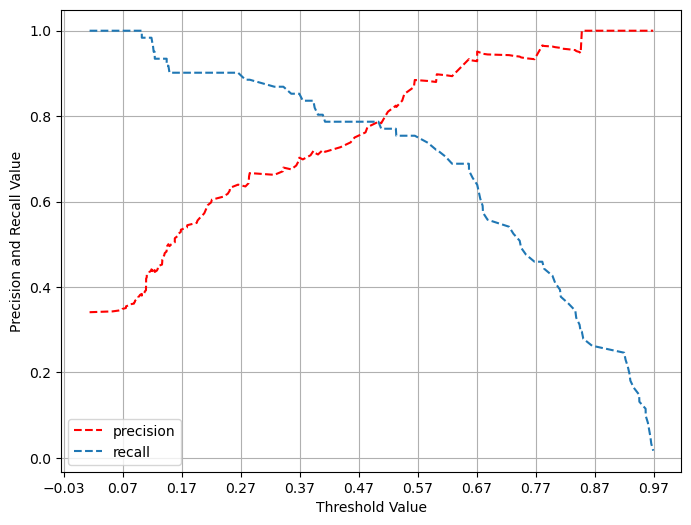

In [28]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def precision_recall_curve_plot(y_test, pred_proba_c1):
    precision, recall, threshold = precision_recall_curve(y_test, pred_proba_c1)

    plt.figure(figsize=(8,6))
    threshold_boundary = threshold.shape[0]
    plt.plot(threshold, precision[0:threshold_boundary], linestyle='--', label="precision", color="red")
    plt.plot(threshold, recall[0:threshold_boundary], linestyle="--", label="recall")

    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    
    plt.xlabel("Threshold Value")
    plt.ylabel("Precision and Recall Value")
    plt.legend()
    plt.grid()
    plt.show()

precision_recall_curve_plot(Y_test, pred_proba[:, 1])





### F1 Score

F1 = 2 / { (1 / recall) + (1 / precision) } = 2 * precision * recall / (recall + precision)

* sklearn.metrics.f1_score


In [41]:
from sklearn.metrics import f1_score

binarizer = Binarizer(threshold=thr)
pred_tmp = pred_proba[:, 1].reshape(-1, 1)

for thr in [0.4, 0.45, 0.5, 0.55, 0.6]:
    binarizer = Binarizer(threshold=thr)
    custom_pred = binarizer.fit_transform(pred_tmp)

    print(f"Confusion Matrix: Threshold({thr})")
    print(confusion_matrix(custom_pred, Y_test))
    print(f"Accuracy_Score: {np.round(accuracy_score(custom_pred, Y_test), 5)}")
    print(f"Precision_Score: {np.round(precision_score(custom_pred, Y_test), 5)}")
    print(f"Recall_Score: {np.round(recall_score(custom_pred, Y_test), 5)}")
    print(f"F1_Score: {np.round(f1_score(custom_pred, Y_test), 5)}")
    print("--\n")

Confusion Matrix: Threshold(0.4)
[[98 12]
 [20 49]]
Accuracy_Score: 0.82123
Precision_Score: 0.80328
Recall_Score: 0.71014
F1_Score: 0.75385
--

Confusion Matrix: Threshold(0.45)
[[101  13]
 [ 17  48]]
Accuracy_Score: 0.8324
Precision_Score: 0.78689
Recall_Score: 0.73846
F1_Score: 0.7619
--

Confusion Matrix: Threshold(0.5)
[[105  13]
 [ 13  48]]
Accuracy_Score: 0.85475
Precision_Score: 0.78689
Recall_Score: 0.78689
F1_Score: 0.78689
--

Confusion Matrix: Threshold(0.55)
[[111  15]
 [  7  46]]
Accuracy_Score: 0.87709
Precision_Score: 0.7541
Recall_Score: 0.86792
F1_Score: 0.80702
--

Confusion Matrix: Threshold(0.6)
[[112  17]
 [  6  44]]
Accuracy_Score: 0.87151
Precision_Score: 0.72131
Recall_Score: 0.88
F1_Score: 0.79279
--



### ROC(Reciever Operation Characteristic Curve) and AUC(Area Under Curve)

- change rate of True Positive Rate(TPR) / change rate of False Positive Rate(FPR)
- TPR: Sensitivity or Recall, Standard level that the positive result should be predicted. = TP / (FN + TP)
- TNR: Specificity, Standard level that the negative result should be predicted. = TN / (FP + TN)
- FPR: FP / (FP + TN) = 1 - TNR